In [4]:
import scanit
import scanpy as sc
import pandas as pd
import anndata
import numpy as np
import SpatialDE
from scipy import sparse
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import SpectralClustering, KMeans
import matplotlib.pyplot as plt
import stlearn as st
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import normalized_mutual_info_score

In [5]:
adata76 = sc.read_h5ad('/Users/oliviaguo/Documents/Undergraduate/Year2/M2R_Graph-based_Clustering/151676.h5ad')

# Preprocessing
adata76_sp = adata76.copy()
sc.pp.normalize_total(adata76_sp)
gene = adata76_sp.X.toarray()
gene_df = pd.DataFrame(gene, index=adata76_sp.obs_names, columns=adata76_sp.var_names)
pts = adata76_sp.obsm["spatial"]
pts_df = pd.DataFrame(pts, index=adata76_sp.obs_names, columns=["x", "y"])
gene_df.index.name, pts_df.index.name = "index", "index"
results = SpatialDE.run(pts_df, gene_df)
svg_genes = results[results['qval'] < 0.05]
sc.pp.log1p(adata76_sp)

Models: 100%|██████████| 10/10 [54:10<00:00, 325.08s/it]


In [25]:
n_sv_genes = 50
top_sv_genes = svg_genes.sort_values("qval").head(n_sv_genes)
svg = list(top_sv_genes["g"])
adata76_sp = adata76[:, svg]

In [26]:
adata76_sp = adata76_sp.copy()
adata76_sp.X = adata76_sp.X.toarray()
print(adata76_sp.shape)
print(type(adata76_sp.X))

(3460, 50)
<class 'numpy.ndarray'>


In [27]:
scanit.tl.spatial_graph(adata76_sp, method='alpha shape', alpha_n_layer=1, knn_n_neighbors=5)
scanit.tl.spatial_representation(adata76_sp, n_h=10, n_epoch=2000, lr=0.001, device='mps', n_consensus=2, projection='mds', 
    python_seed=0, torch_seed=0, numpy_seed=0)

Epoch: 000, Loss: 2.2753
Epoch: 500, Loss: 0.2808
Epoch: 1000, Loss: 0.1909
Epoch: 1500, Loss: 0.1450
Epoch: 1999, Loss: 0.1142
Epoch: 000, Loss: 2.8195
Epoch: 500, Loss: 0.4523
Epoch: 1000, Loss: 0.2166
Epoch: 1500, Loss: 0.1638
Epoch: 1999, Loss: 0.1346


/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.13/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


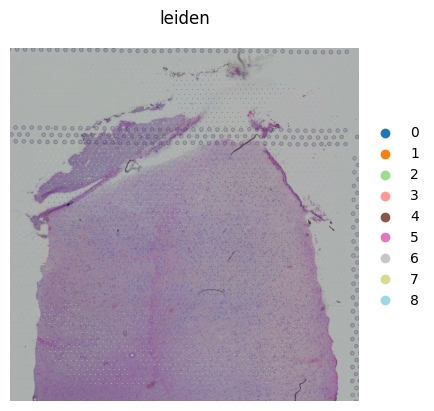

<Figure size 640x480 with 0 Axes>

In [28]:
sc.pp.neighbors(adata76_sp, use_rep='X_scanit', n_neighbors=10)
# finds clusters within that graph using Leiden clustering algorithm.
sc.tl.leiden(adata76_sp, resolution=0.15)
sc.pl.spatial(adata76_sp, spot_size=20, color='leiden', frameon=False, palette='tab20')
plt.savefig("151676_leiden.png", dpi=300, bbox_inches='tight')

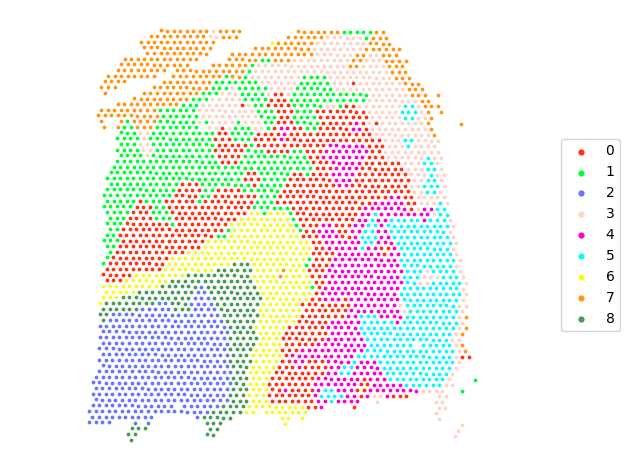

In [29]:
import plotly
pts = adata76_sp.obsm['spatial']
color_list = plotly.colors.qualitative.Light24
labels_pred = np.array( adata76_sp.obs['leiden'], int )
labels = list(set(labels_pred))
labels = list(np.sort(labels))
for j in range(len(labels)):
    label = labels[j]
    idx = np.where(labels_pred == label)[0]
    plt.scatter(pts[idx,0], pts[idx,1], c=color_list[j], label = label, s=3)
plt.axis('equal')
plt.axis('off')
plt.legend(markerscale=2, loc='center left', bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.savefig("151676_spatial.png", dpi=300, bbox_inches='tight')

In [30]:
encoder = LabelEncoder()

flat_arr = np.array([adata76_sp.obs['sce.layer_guess']]).ravel()
encoder.fit(flat_arr)

label_true = encoder.transform(flat_arr)

In [31]:
normalized_mutual_info_score(label_true, adata76_sp.obs['leiden'])

0.5111846554608409

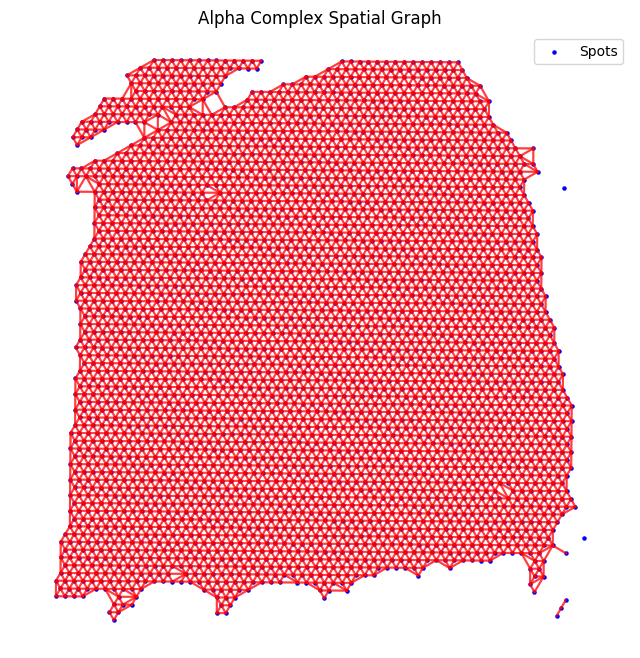

In [24]:
edges = adata76_sp.obsp['scanit-graph']

row, col = edges.nonzero()

plt.figure(figsize=(8,8))
plt.scatter(pts[:,0], pts[:,1], c='blue', s=5, label='Spots')

for i, j in zip(row, col):
    x = [pts[i,0], pts[j,0]]
    y = [pts[i,1], pts[j,1]]
    plt.plot(x, y, color='red', alpha=0.5)

plt.title('Alpha Complex Spatial Graph')
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.show()